In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt

import glob
from pathlib import Path

from scipy.stats import pearsonr

## Load Bacterial SwissProt

In [2]:
swiss_df = pd.read_hdf('../data/bacterial_swissprot.h5')
swiss_df.head()

,accessions,sequence_length,sequence,description,InterPro,GO,KO,Gene3D,Pfam,KEGG,...,Superkingdom,Kingdom,Phylum,Class,Order,Family,Subfamily,Genus,Species,Transmembrane
entry_name,,,,,,,,,,,,,,,,,,,,,
12AH_CLOS4,P21215,29.0,MIFDGKVAIITGGGKAKSIGYGIAVAYAK,RecName: Full=12-alpha-hydroxysteroid dehydrog...,IPR036291,GO:0047013||GO:0030573||GO:0016042,NaN,NaN,NaN,NaN,...,Bacteria,NaN,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,NaN,Clostridium,NaN,0.0
12KD_MYCSM,P80438,24.0,MFHVLTLTYLCPLDVVXQTRPAHV,RecName: Full=12 kDa protein; Flags: Fragment;,NaN,NaN,NaN,NaN,NaN,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,NaN,Mycolicibacterium,NaN,0.0
12OLP_LISIN,Q92AT0,1086.0,MTMLKEIKKADLSAAFYPSGELAWLKLKDIMLNQVIQNPLENRLSQ...,"RecName: Full=1,2-beta-oligoglucan phosphoryla...",IPR008928||IPR012341||IPR033432,GO:0016740,K21298,1.50.10.10,PF17167,lin:lin1839,...,Bacteria,NaN,Firmicutes,Bacilli,Bacillales,Listeriaceae,NaN,Listeria,NaN,NaN
12S_PROFR,Q8GBW6||Q05617,611.0,MAENNNLKLASTMEGRVEQLAEQRQVIEAGGGERRVEKQHSQGKQT...,RecName: Full=Methylmalonyl-CoA carboxyltransf...,IPR034733||IPR000438||IPR029045||IPR011763||IP...,GO:0009317||GO:0003989||GO:0047154||GO:0006633,NaN,NaN,PF01039,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Propionibacteriales,Propionibacteriaceae,NaN,Propionibacterium,NaN,0.0
14KD_MYCBO,P0A5B8||A0A1R3Y251||P30223||X2BJK6,144.0,MATTLPVQRHPRSLFPEFSELFAAFPSFAGLRPTFDTRLMRLEDEM...,RecName: Full=14 kDa antigen; AltName: Full=16...,IPR002068||IPR008978,GO:0005618||GO:0005576,NaN,2.60.40.790,PF00011,NaN,...,Bacteria,NaN,Actinobacteria,Actinobacteria,Corynebacteriales,Mycobacteriaceae,NaN,Mycobacterium,NaN,0.0


## Load Label Recovery Results

In [3]:
def read_results(results_path):
    results_path = Path(results_path)

    return pd.concat({
        (repeat, path.stem): pd.read_pickle(path) 
        for repeat in range(1)
        for path in results_path.glob(f'repeat_{repeat}/*.pkl')
    }, names=['Repeat', 'Label', 'id']).reset_index()

In [4]:
taxonomic_labels = ['Phylum', 'Genus', 'Order', 'Family']

rec_results = read_results(f'../01-label-recovery/results_deep_embeddings/')
rec_results = rec_results.query('Label not in @taxonomic_labels')
rec_results.head()

,Repeat,Label,id,entry_name,Metric,Value,k
0,0,InterPro,0,14KL_OCHA4,IoU,1.0,1
1,0,InterPro,1,17KD_RICPR,IoU,1.0,1
2,0,InterPro,2,18K1_MYCAV,IoU,1.0,1
3,0,InterPro,3,18K2_MYCAV,IoU,1.0,1
4,0,InterPro,4,18K2_MYCIT,IoU,1.0,1


In [5]:
swiss_df['REE'] = 1 - rec_results.groupby('entry_name')['Value'].mean()

In [6]:
annotations = [
    'InterPro',
    'GO',
    'KO',
    'Pfam',
    'SUPFAM',
    'EC number',
    'Gene3D',
]

## Count log-averaged size of the functional classes

In [7]:
a_counts = []
for a in annotations:
    name = f'{a}_count'
    swiss_df[name] = swiss_df[a].map(swiss_df[a].value_counts().to_dict())
    
    a_counts.append(name)

In [8]:
swiss_df['log_averaged_class_size'] = np.log(swiss_df[a_counts]).mean(axis=1)

In [9]:
sdf = swiss_df[swiss_df['log_averaged_class_size'].notnull() & swiss_df['REE'].notnull()]
r, p = pearsonr(sdf['log_averaged_class_size'], sdf['REE'])

print(f'Pearson R: {r}, p-value: {p}, N: {len(sdf)}')

Pearson R: -0.7759106642657742, p-value: 0.0, N: 200115


### Plot 

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x576 with 0 Axes>

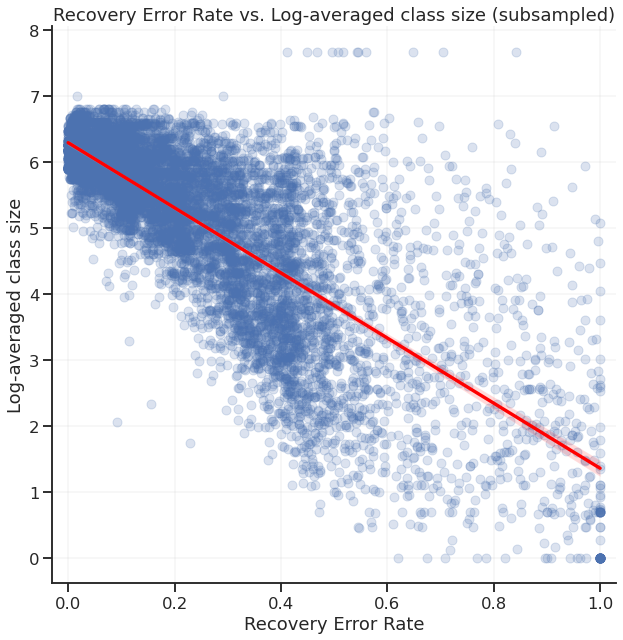

In [10]:
sns.set('talk', 'ticks')
plt.figure(figsize=(12,8))
# sns.histplot(swiss_df, x="rec_error", y="mean_class_size")
sns.lmplot(data=swiss_df.sample(10000), x="REE", y="log_averaged_class_size", size=9, scatter_kws=dict(alpha=0.2), ci=99, line_kws=dict(color='red'))
plt.xlim(-0.03, 1.03)

plt.title('Recovery Error Rate vs. Log-averaged class size (subsampled)')
plt.xlabel('Recovery Error Rate')
plt.ylabel('Log-averaged class size')
plt.grid(alpha=0.2)

## Unknown words

In [11]:
swiss_df['is_uncharacterized'] = swiss_df['description'].str.lower().str.contains('uncharacterized')
swiss_df['is_putative'] = swiss_df['description'].str.lower().str.contains('putative')
swiss_df['is_probable'] = swiss_df['description'].str.lower().str.contains('probable')

In [12]:
swiss_df['is_known'] = ((swiss_df['is_uncharacterized'] + swiss_df['is_putative'] + swiss_df['is_probable']).astype('float') > 0).map({True: 'Unknown',  False: "Known"})

In [13]:
n_labels = 10
labels = [f'{i/n_labels}-{(i+1)/n_labels}' for i in range(n_labels)]
swiss_df['REE_cat'] = pd.cut(swiss_df['REE'], n_labels, labels=labels)

In [14]:
counts = swiss_df.groupby('REE_cat')['is_known'].value_counts().unstack()

counts['putative'] = swiss_df.groupby('REE_cat')['is_putative'].value_counts().unstack()[True]
counts['probable'] = swiss_df.groupby('REE_cat')['is_probable'].value_counts().unstack()[True]
counts['uncharacterized'] = swiss_df.groupby('REE_cat')['is_uncharacterized'].value_counts().unstack()[True]

counts['total'] = counts['Known'] + counts['Unknown']
counts['unknown_prc'] = counts['Unknown'] / counts['total'] * 100
counts['putative_prc'] = counts['putative'] / counts['total'] * 100
counts['probable_prc'] = counts['probable'] / counts['total'] * 100
counts['uncharacterized_prc'] = counts['uncharacterized'] / counts['total'] * 100
# counts = counts.reset_index().melt(id_vars=['rec_cat'], value_vars=['unknown_prc'] value_name='count')
counts

is_known,Known,Unknown,putative,probable,uncharacterized,total,unknown_prc,putative_prc,probable_prc,uncharacterized_prc
REE_cat,,,,,,,,,,
0.0-0.1,64484,793,175,618,NaN,65277,1.214823,0.268088,0.946735,NaN
0.1-0.2,36208,1954,804,1142,8.0,38162,5.120277,2.106808,2.992506,0.020963
0.2-0.3,26740,1464,641,657,166.0,28204,5.190753,2.272727,2.329457,0.588569
0.3-0.4,23936,2691,849,1416,427.0,26627,10.106283,3.188493,5.317910,1.603635
0.4-0.5,17472,3023,1029,946,1055.0,20495,14.749939,5.020737,4.615760,5.147597
0.5-0.6,5659,1534,486,326,734.0,7193,21.326289,6.756569,4.532184,10.204365
0.6-0.7,3221,946,276,188,488.0,4167,22.702184,6.623470,4.511639,11.711063
0.7-0.8,2398,825,219,133,482.0,3223,25.597270,6.794912,4.126590,14.955011
0.8-0.9,1990,858,190,111,560.0,2848,30.126404,6.671348,3.897472,19.662921


In [15]:
counts = counts.reset_index().melt(
    id_vars=['REE_cat'],
    var_name='kind',
    value_vars=['unknown_prc', 'putative_prc', 'probable_prc', 'uncharacterized_prc'],
    value_name='prc'
)

In [16]:
palette = [
    "#8d5eac",
    "#3b66b6",
    "#d3759e",
    "#2fc7bd",
]

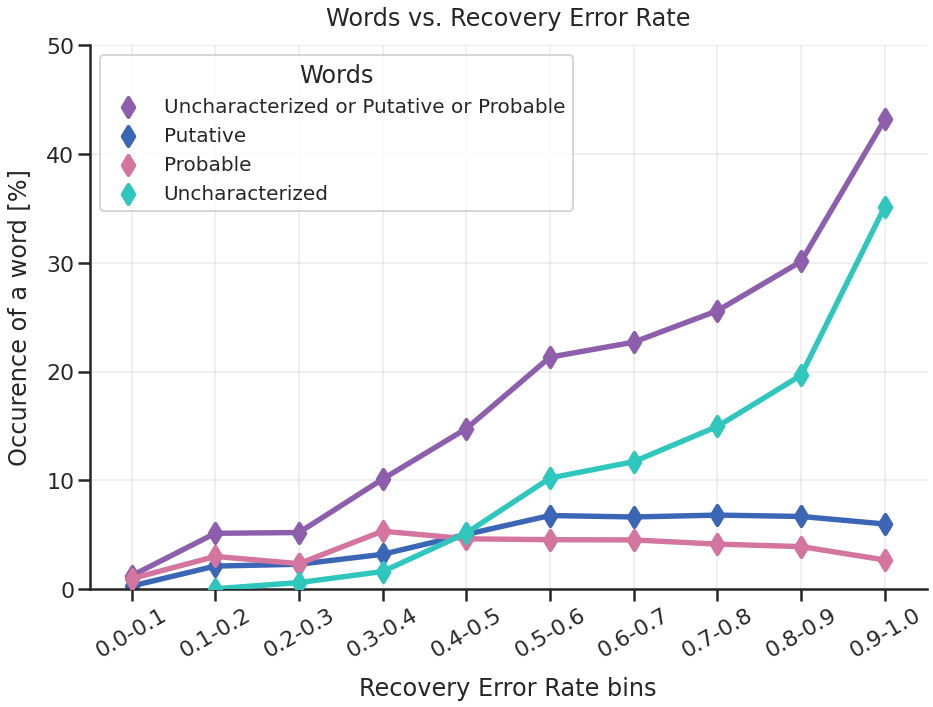

In [17]:
sns.set('poster', 'ticks')
plt.figure(figsize=(15, 10))
sns.pointplot(data=counts.reset_index(), x='REE_cat', y='prc', hue='kind', markers='d', palette=palette)
plt.grid(alpha=0.3)
sns.despine()
plt.xlabel('Recovery Error Rate bins', labelpad=15)
plt.ylabel('Occurence of a word [%]', labelpad=15)
plt.title('Words vs. Recovery Error Rate', pad=20)
plt.xticks(rotation=30)
plt.ylim(0, 50)

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    title='Words',
    handles=handles,
    labels=['Uncharacterized or Putative or Probable', 'Putative' ,'Probable', 'Uncharacterized'],
    fontsize=20
#     loc=''
)

## Groupby Kegg level 2

In [18]:
kegg_df = pd.read_csv('KEGG_categories.csv.gz', index_col=0)
kegg_df

,level_4,level_3,level_2,level_1
0,K00001,ko00010 Glycolysis / Gluconeogenesis,Carbohydrate metabolism,Metabolism
1,K00002,ko00010 Glycolysis / Gluconeogenesis,Carbohydrate metabolism,Metabolism
2,K00003,"ko00260 Glycine, serine and threonine metabolism",Amino acid metabolism,Metabolism
3,K00004,ko00650 Butanoate metabolism,Carbohydrate metabolism,Metabolism
4,K00005,ko00640 Propanoate metabolism,Carbohydrate metabolism,Metabolism
...,...,...,...,...
23379,K24194,ko02000 Transporters,Protein families: signaling and cellular proce...,Brite Hierarchies
23380,K24195,ko02000 Transporters,Protein families: signaling and cellular proce...,Brite Hierarchies
23381,K24196,ko99984 Nucleotide metabolism,Unclassified: metabolism,Not Included in Pathway or Brite
23382,K24197,ko04131 Membrane trafficking,Protein families: genetic information processing,Brite Hierarchies


In [19]:
swiss_kg = swiss_df.merge(kegg_df, left_on='KO', right_on='level_4')

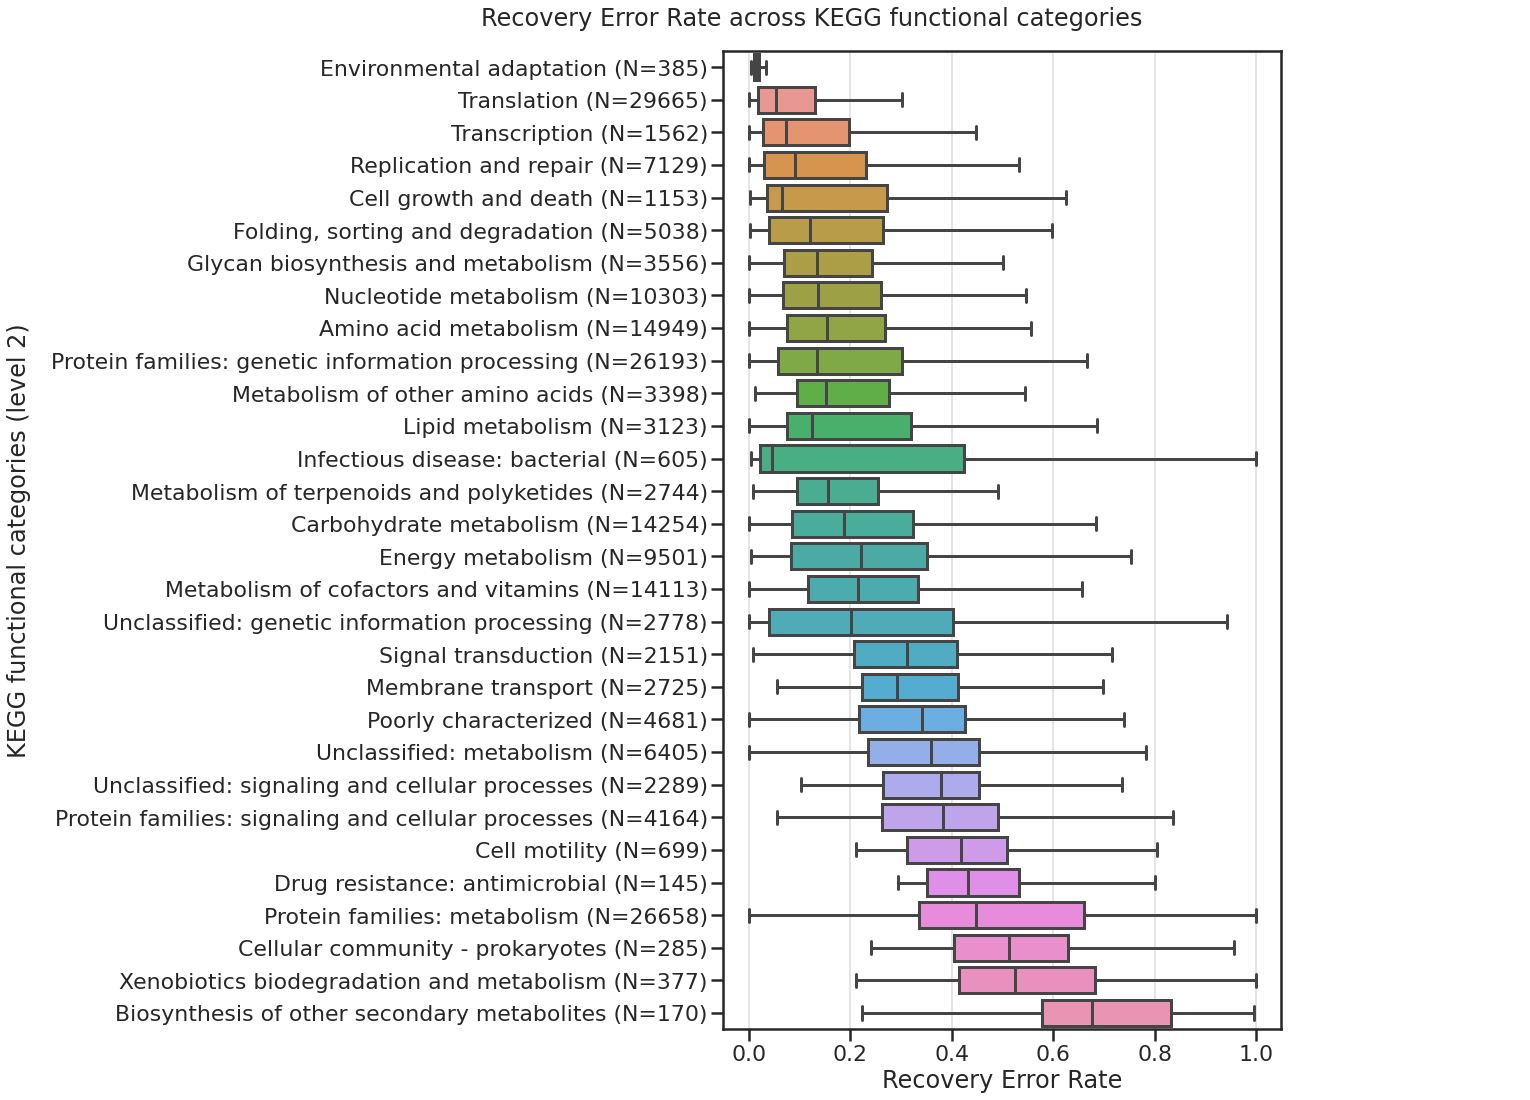

In [21]:
level = 'level_2'

level_counts = swiss_kg[level].value_counts()
level_means = swiss_kg.groupby(level)['REE'].mean()

filtered = level_counts[level_counts > 100].index

plt.figure(figsize=(10,18))
sns.boxplot(
    data=swiss_kg,
    x='REE',
    y=level,
    showfliers=False,
    order=level_means.loc[filtered].sort_values().index
)
plt.grid(axis='x', alpha=0.5)
plt.xlabel('Recovery Error Rate')
plt.ylabel(f'KEGG functional categories ({level.replace("_", " ")})', labelpad=20)
plt.title('Recovery Error Rate across KEGG functional categories' + 50*' ', pad=25, ha='center')

labels = [item.get_text() for item in plt.gca().get_yticklabels()]
plt.gca().set_yticklabels([
    f"{label} (N={level_counts.loc[label]})"
    for label in labels
]);